# 10X 空间转录组学分析流程
## 以 10X Visium Human Breast Cancer 乳腺癌样本为例
### 链接: https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Breast_Cancer_Block_A_Section_1

### 数据下载及格式介绍：
### 下载Feature / barcode matrix HDF5 (filtered) 以及 Spatial imaging data

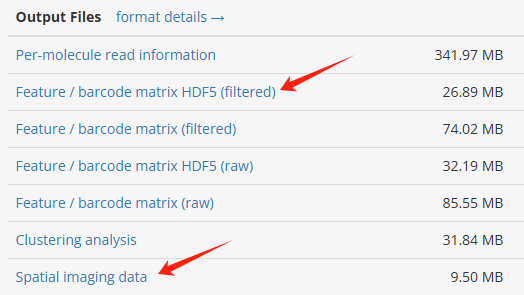

### ①解压"V1_Breast_Cancer_Block_A_Section_1_spatial.tar.gz"
### ②将"V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5"重命名为："filtered_feature_bc_matrix.h5"
### 最终格式如下 ：

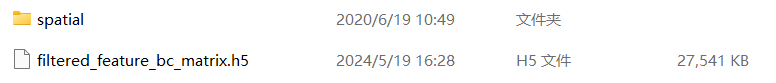

## spatial文件夹: 包括 空间位置信息 及 H&E 染色病理组织切片

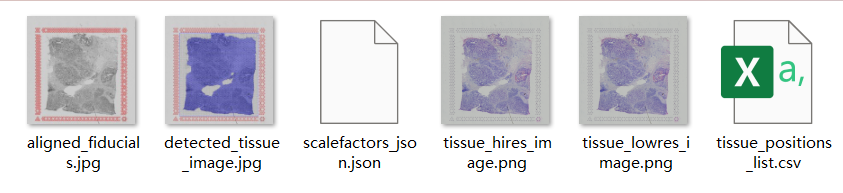

## filtered_feature_bc_matrix.h5: 测序表达矩阵.h5文件

## 下面进入R语言，读取数据并创建Seurat对象

In [ ]:
#加载R包
library(Seurat)
library(hdf5r)
library(ggplot2)
library(tidyverse)
library(cowplot)

In [ ]:
#创建空间转录组Seurat对象
BRCA1 <-Load10X_Spatial(
       data.dir ="E:/DATA/BRCA1/",                  #上一步数据下载路径
       filename = "filtered_feature_bc_matrix.h5",  #h5矩阵文件名
       slice ="BRCA1")                              # H&E 图片名(自定义)

In [ ]:
BRCA1$orig.ident <-"BRCA1" 
BRCA1

In [ ]:
#可视化每个sport的空间计数
P1<-VlnPlot(BRCA1, features = "nCount_Spatial", pt.size = 0.1,group.by = 'orig.ident') + NoLegend()
P2<-SpatialFeaturePlot(BRCA1, features = "nCount_Spatial") + theme(legend.position = "right")
plot_grid(P1, P2)

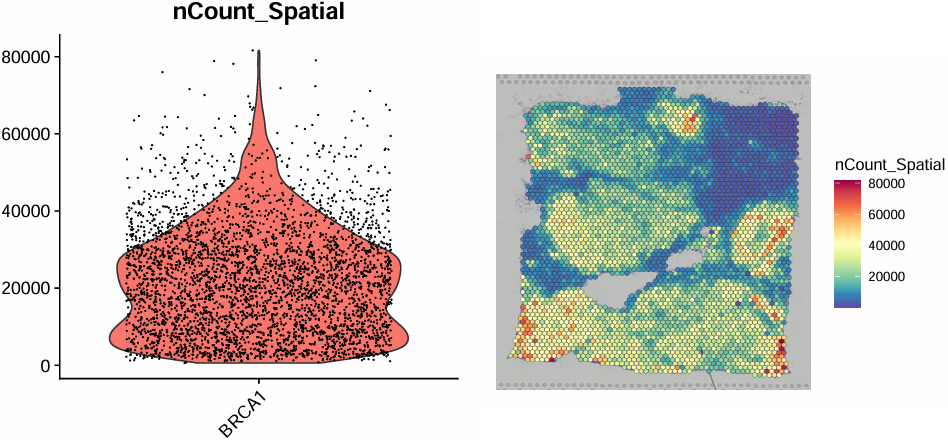

In [ ]:
##SCT标准化流程
BRCA1 <- SCTransform(BRCA1, assay = "Spatial", verbose = FALSE)

#主成分分析
BRCA1 <- RunPCA(BRCA1, assay = "SCT", verbose = FALSE) 

#数据聚类
BRCA1<- FindNeighbors(BRCA1, reduction = "pca", dims = 1:10)
BRCA1<- FindClusters(BRCA1, verbose = FALSE,resolution = 0.4)

#空间聚类结果可视化
P3<-SpatialPlot(BRCA1, label = TRUE, label.size = 5)

#UMAP降维
BRCA1 <- RunUMAP(BRCA1, reduction = "pca", dims = 1:10)
#UMAP降维可视化
P4 <- DimPlot(BRCA1, reduction = "umap", label = TRUE)
P3+P4

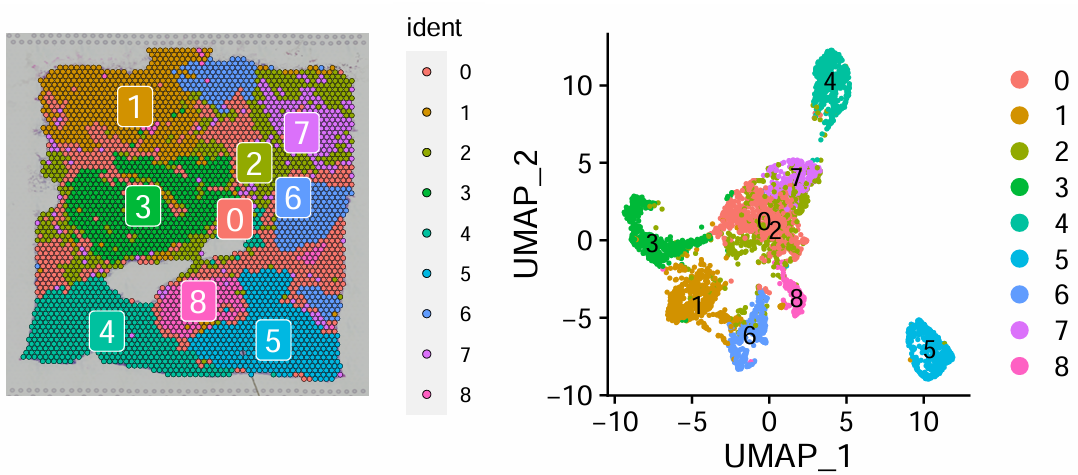

In [ ]:
#查看感兴趣基因空间表达分布,以上皮细胞的Marker基因为例
SpatialFeaturePlot(BRCA1, features =c("EPCAM","CD3D"))

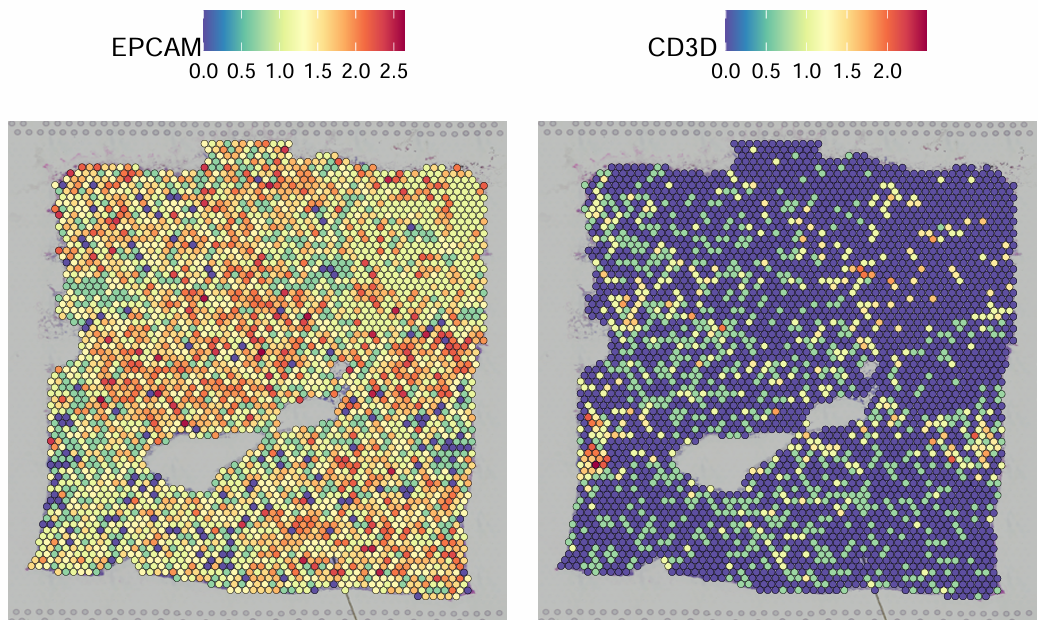

### 图解： EPCAM高表达区域为癌灶区域，CD3D高表达区域为癌旁免疫微环境区域

## 空间区域划分

#### 根据典型的上皮细胞Marker基因的空间表达，以及H&E染色情况，初步对病理组织切片进行空间区域划分

In [ ]:
#气泡图展示上皮细胞在不同cluster的表达均值
P5<-DotPlot(BRCA1, features =c("EPCAM","KRT8"),cols = c('#EEE9E9','#5D478B'))

#展示空间聚类cluster分布
P6<-SpatialPlot(BRCA1,group.by = 'seurat_clusters',label = T)

#展示H&E病理组织切片
P7<-SpatialPlot(BRCA1,pt.size.factor = 0,group.by = 'orig.ident')
plot_grid(P5+P6+P7)

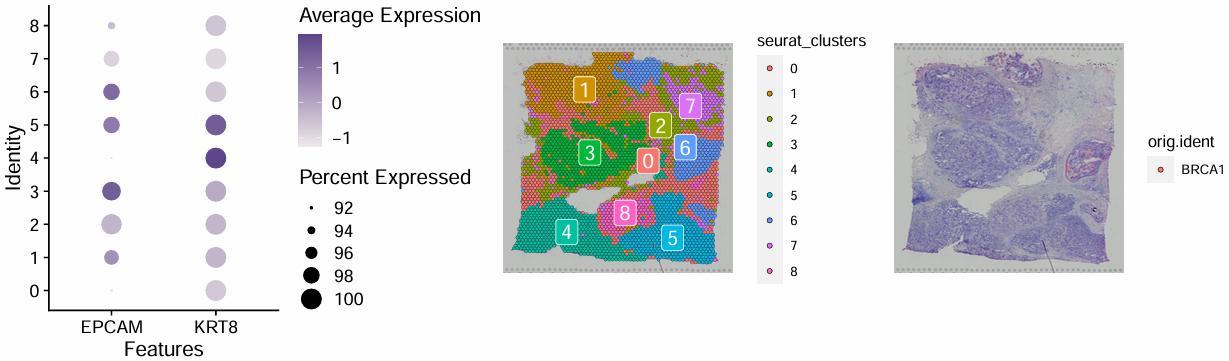

#### ----------左：上皮细胞在不同cluster的表达均值----------中：空间聚类cluster分布----------右：病理组织切片的H&E组织切片----------
#### 在H&E染色下(右图），癌细胞的细胞核显示出更加浓密和显著的染色，这是由于癌细胞的核质较大、细胞核形态不规则以及核分裂活跃等特点所致。这种深染色现象有助于在组织切片中更容易地识别和定位癌灶。
#### 根据上图（左）的marker基因表达 及 H&E染色情况（右），初步将Cluster1,3,4,5,6,8 定义为癌灶区（T）, 其他的 Cluster 定义为癌旁区（PT）;（后续应结合CNV分析结果，此处仅做示例）

In [ ]:
##区域定义
BRCA1@meta.data$Region<-NA
BRCA1@meta.data$Region[BRCA1@meta.data$seurat_clusters %in% c('1','3','4','5','6','8')] <- "T"
BRCA1@meta.data$Region[BRCA1@meta.data$seurat_clusters %in% c('0','2','7')] <- "PT"

#可视化区域划分结果
SpatialPlot(BRCA1, label = T, label.size = 5,group.by = 'Region',cols = c('PT'='#FFA07A','T'='#5D478B'))

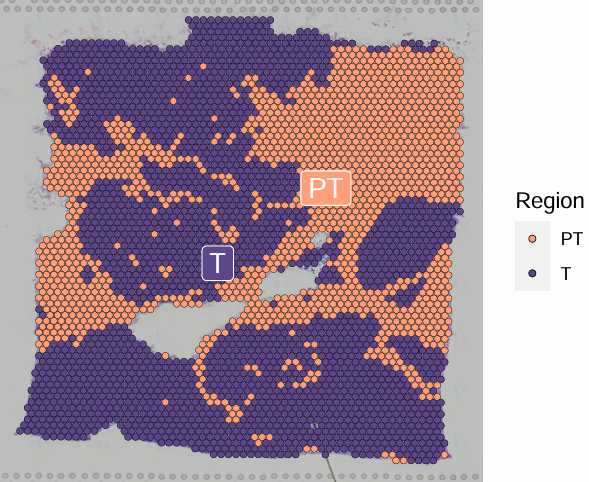

In [ ]:
#切换Idents为上面定义的Region
Idents(BRCA1)<-BRCA1$Region

#找到各区域的标记物，并只报道阳性位点（上调基因）
markers <- FindAllMarkers(BRCA1, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

#找到各区域top10基因
top10<-markers %>%
  group_by(cluster) %>%
  top_n(n = 10, wt = avg_log2FC)


#可视化top10上调差异基因热图
DoHeatmap(BRCA1, features = top10$gene,group.colors = c('PT'='#FFA07A','T'='#5D478B')) + NoLegend()

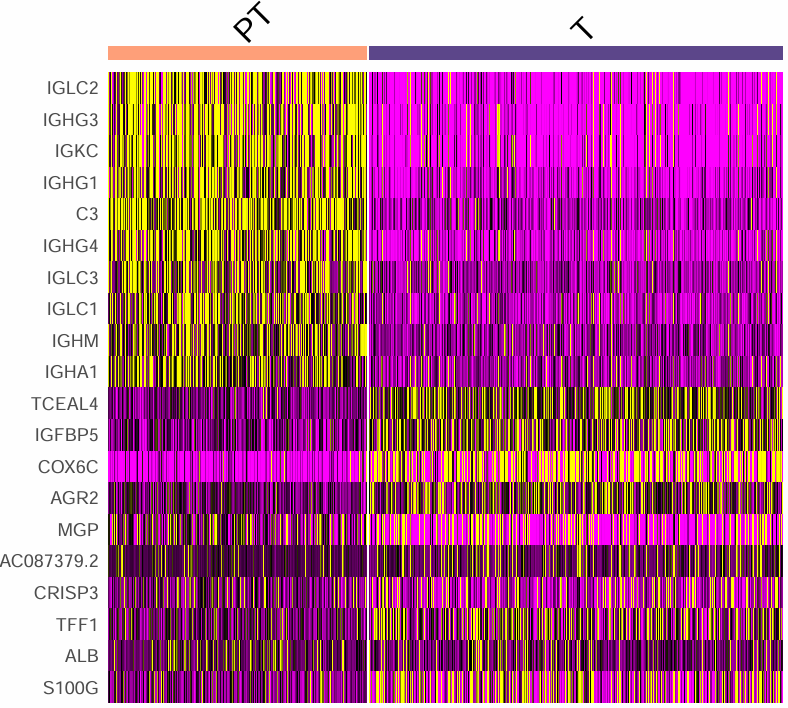

In [ ]:
#对各区域差异基因进行KEGG通路富集分析
library(clusterProfiler)

#将基因SYMBOL转换为ENTREZID
gid <- bitr(unique(markers$gene), 'SYMBOL', 'ENTREZID', OrgDb= 'org.Hs.eg.db')
markers <- full_join(markers, gid, by=c('gene' = 'SYMBOL'))

In [ ]:
#KEGG通路富集分析
KEGG ="hsa" = compareCluster(ENTREZID ~ cluster, data = markers, fun='enrichKEGG',organism="hsa")

#可视化各区域TOP5通路结果
dotplot(KEGG , label_format=40) + theme(axis.text.x = element_text(angle=45, hjust=1)) + scale_color_gradient(high="#5D478B",low="#FFA07A")


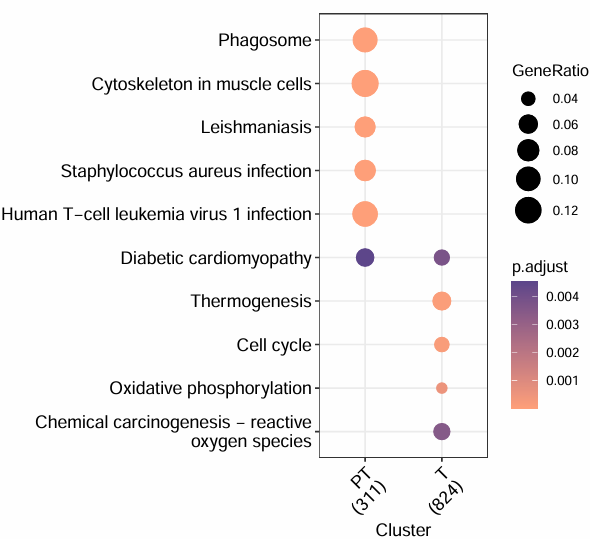

### 从KEGG通路富集结果来看，T癌灶区域、PT癌旁区域差异显著

#### 癌灶区域（T）的Cell cycle显著富集，肿瘤区域细胞周期的显著富集可能反映了肿瘤细胞在增殖和基因组稳定性方面存在的异常，符合肿瘤的生物学特征；

#### 而癌旁（PT）区域的Phagosome通路富集，Phagosome通路的富集可能表明在癌旁区域存在着增强的免疫反应。这可能包括巨噬细胞和其他免疫细胞对癌细胞的吞噬和降解。

In [ ]:
#保存分析结果，以便下期使用
save(BRCA1,file = 'BRCA1.rdata')